In [56]:
# https://www.kaggle.com/competitions/sberbank-russian-housing-market/data

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [58]:
# Load data
house_data = pd.read_csv("Data/sberbank_housing.csv", index_col=0, low_memory=True)
house_data.head()

,id,timestamp,price_doc,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,product_type,ecology,sub_area,raion_popul,kindergarten_km,school_km,park_km,railroad_km,metro_min_walk
0,1,2011-08-20,5850000,43,27.0,NaN,4.0,NaN,NaN,NaN,NaN,Investment,good,Bibirevo,155572,0.145700,0.177975,2.158587,1.305159,13.575119
1,2,2011-08-23,6000000,34,19.0,NaN,3.0,NaN,NaN,NaN,NaN,Investment,excellent,Nagatinskij Zaton,115352,0.147754,0.273345,0.550690,0.694536,7.620630
2,3,2011-08-27,5700000,43,29.0,NaN,2.0,NaN,NaN,NaN,NaN,Investment,poor,Tekstil'shhiki,101708,0.049102,0.158072,0.374848,0.700691,17.351515
3,4,2011-09-01,13100000,89,50.0,NaN,9.0,NaN,NaN,NaN,NaN,Investment,good,Mitino,178473,0.179441,0.236455,0.078090,1.999265,11.565624
4,5,2011-09-05,16331452,77,77.0,NaN,4.0,NaN,NaN,NaN,NaN,Investment,excellent,Basmannoe,108171,0.247901,0.376838,0.258289,0.084113,8.266305


In [59]:
print(f"Original dataset shape: {house_data.shape}")
print(f"Missing values per column:\n{house_data.isnull().sum()}")

Original dataset shape: (27000, 20)
Missing values per column:
id                     0
timestamp              0
price_doc              0
full_sq                0
life_sq             5537
kitch_sq            9572
floor                167
max_floor           9572
build_year         12869
num_room            9572
state              13067
product_type           0
ecology                0
sub_area               0
raion_popul            0
kindergarten_km        0
school_km              0
park_km                0
railroad_km            0
metro_min_walk        14
dtype: int64


DATA LOADING AND INITIAL EXPLORATION

In [60]:
# Clean column names
house_data.columns = [c.lower().strip().replace(" ", "_") for c in house_data.columns]

# Drop non-predictive columns
house_data = house_data.drop(columns=["timestamp", "id"])

In [61]:
# Display basic dataset information
print(f"Original dataset shape: {house_data.shape}")
print("Dataset contains {0} rows and {1} columns".format(house_data.shape[0], house_data.shape[1]))

Original dataset shape: (27000, 18)
Dataset contains 27000 rows and 18 columns


WHY CHECK TARGET DISTRIBUTION?

1. Normality Assumption - residuals follow bell-shaped curve distribution
2. Homoscedacity - residuals are scattered randomaly - no patterns

Target distribution is a significant factor for both.

Homoscedastic + Normal residuals (IDEAL)

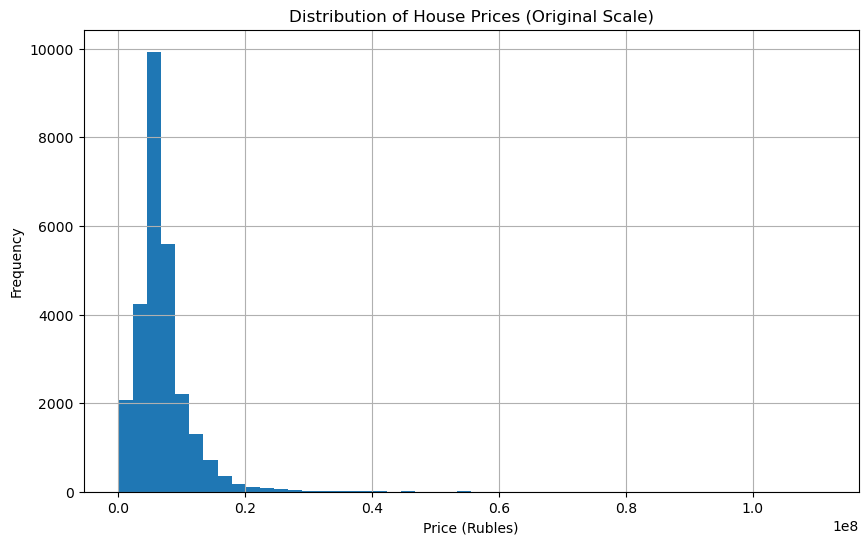

In [62]:
# Visualize the distribution of our target variable (house prices)
house_data["price_doc"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of House Prices (Original Scale)")
plt.xlabel("Price (Rubles)")
plt.ylabel("Frequency")
plt.show()

In [63]:
# Let's apply log transfrom to the target variable to reduce skewness
house_data["price_doc"] = np.log1p(house_data["price_doc"])

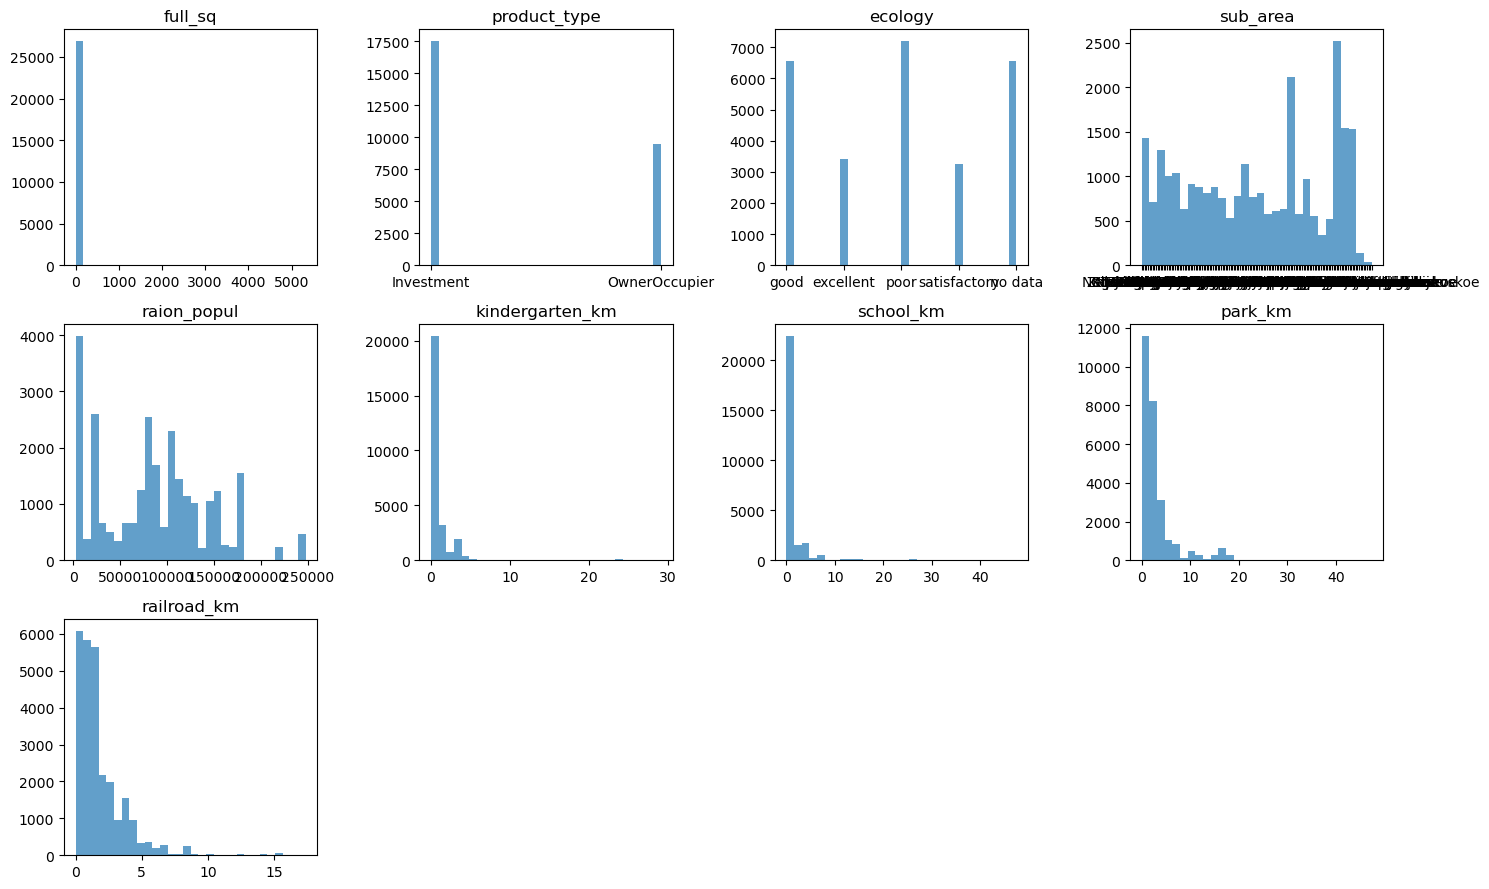

In [64]:
# Let's look at the distribution of the predictors/features
# Get features (exclude target)
features = house_data.drop('price_doc', axis=1).dropna(axis=1)

# Create grid
n_cols = 4
n_rows = int(np.ceil(len(features.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(features.columns):
    axes[i].hist(features[col], bins=30, alpha=0.7)
    axes[i].set_title(col)
    
# Hide unused subplots
for i in range(len(features.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Let's apply RobustScaler to the features since a lot of the features are highly right-skewed (some serious outliers), having high spikes around 0's, and vastly different scales

SPLIT DATA FIRST

80% for Training; 20% for Testing

In [65]:
X = house_data.drop("price_doc", axis=1)
y = house_data["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

numeric_complete_train = X_train.select_dtypes(include=[np.number]).dropna(axis=1)
scaler = RobustScaler()
scaler.fit(numeric_complete_train)
numeric_complete_train = scaler.transform(numeric_complete_train)

Training set: (24300, 17)
Test set: (2700, 17)


BASELINE MODEL - MINIMAL PREPROCESSING

Let's perform Grid Search for hyperparameters tuning for our Ridge Regression

In [66]:
estimator = Ridge(random_state=42, max_iter=1000, tol=1e-4)

param_grid = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
}

ridge_reg = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [67]:
ridge_reg.fit(numeric_complete_train, y_train)

,estimator,Ridge(max_ite...ndom_state=42)
,param_grid,"{'alpha': [1e-15, 1e-10, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,100


In [68]:
print("Best value for lambda : ",ridge_reg.best_params_)
print("Best score for cost function: ", ridge_reg.best_score_)

Best value for lambda :  {'alpha': 100}
Best score for cost function:  -0.658002492005199


In [69]:
# Only use numeric columns with no missing values for baseline
baseline_model = ridge_reg.best_estimator_

numeric_complete_test = X_test.select_dtypes(include=[np.number]).dropna(axis=1)
numeric_complete_test = scaler.transform(numeric_complete_test)
baseline_pred = baseline_model.predict(numeric_complete_test)

In [70]:
# Calculate metrics on log scale
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Convert back to dollar scale for interpretation
baseline_pred_dollars = np.expm1(baseline_pred)
y_test_dollars = np.expm1(y_test)
baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))

residuals = y_test - baseline_pred

In [71]:
print(f"   Features used: {len(X_train.columns)} (only complete numeric)")
print(f"   RMSE: {baseline_rmse:.3f} (log scale)")
print(f"   RMSE: {baseline_rmse_dollars:.3f} (dollars scale)")

print(f"\nFeatures used in baseline model:")
print(f"{list(X_train.columns)}")

print("\n" + "="*60)
print("BASELINE MODEL LIMITATIONS:")
print("="*60)
print("Only uses complete numeric features")
print("Ignores categorical information")
print("Cannot handle missing values")
print("No feature engineering")
print("Limited feature set")
#4597319.184 (dollars scale)

   Features used: 17 (only complete numeric)
   RMSE: 0.544 (log scale)
   RMSE: 4401356.699 (dollars scale)

Features used in baseline model:
['full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'state', 'product_type', 'ecology', 'sub_area', 'raion_popul', 'kindergarten_km', 'school_km', 'park_km', 'railroad_km', 'metro_min_walk']

BASELINE MODEL LIMITATIONS:
Only uses complete numeric features
Ignores categorical information
Cannot handle missing values
No feature engineering
Limited feature set


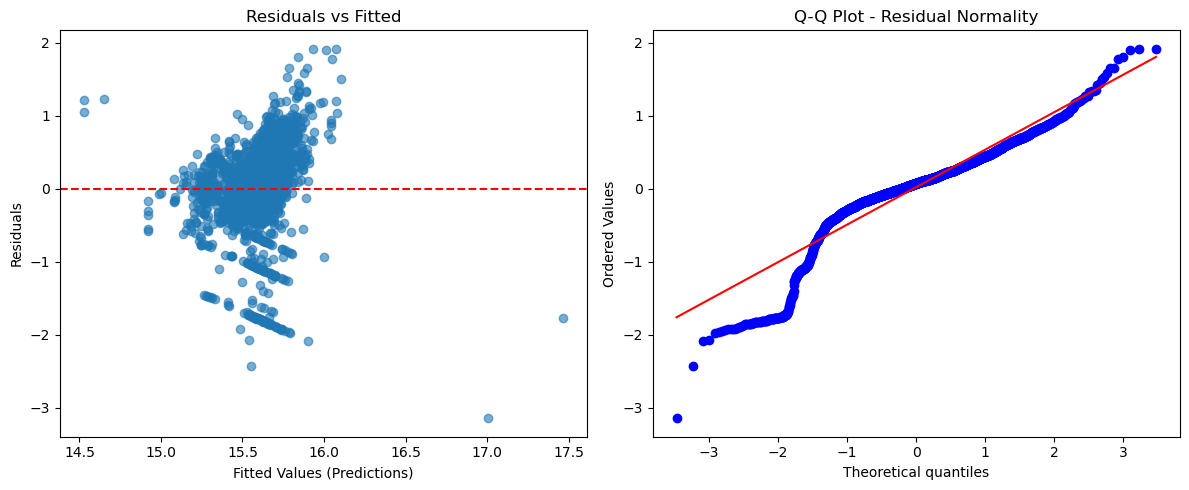

In [72]:
# Calculate residuals
residuals = y_test - baseline_pred

# 1. Check homoscedasticity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_pred, residuals, alpha=0.6)
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(y=0, color='red', linestyle='--')

# 2. Check normality of residuals
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot - Residual Normality")

plt.tight_layout()
plt.show()

Both plots are not ideal, but acceptable, showing some minor deviations rather than major violations

Left Plot - Homoscedasticity: Good

Random cloud of points around y=0 
No obvious funnel/fan pattern 
No strong curved patterns 
Variance looks reasonably constant across prediction range

Right Plot - Normality: Mostly Good with Some Issues

Middle section: Points follow the diagonal line well 
Tails: Some deviation, especially in lower tail 
Overall: Reasonably normal but slightly heavy-tailed 

In [73]:
# save our baseline model's rmse to compare later
baseline_rmse_dollars = str(np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars)))
with open("baseline_rmse_fine_tuned.txt","w") as f:
    f.write(baseline_rmse_dollars)
    f.flush()